## Grid transformations

In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
import xrft
import pyproj
import pygmt

import ensaio
import verde as vd
import boule as bl
import harmonica as hm

import matplotlib.pyplot as plt

In [2]:
figsdir = pathlib.Path("..") / "figs"

Configure PyGMT plots

In [3]:
pygmt.config(
    FONT_ANNOT="11p,Helvetica,black",
    FONT_TITLE="12p,Helvetica,black",
    FONT_LABEL="10p,Helvetica,black",
    MAP_TITLE_OFFSET="0p",
    MAP_FRAME_WIDTH="2p",
)

In [4]:
fname = ensaio.fetch_lightning_creek_magnetic(version=1)
magnetic_grid = xr.load_dataarray(fname)
magnetic_grid

<xarray.DataArray 'total_field_anomaly' (northing: 370, easting: 346)>
array([[  35.        ,   36.19995   ,   36.69995   , ..., -101.099976  ,
        -100.400024  ,  -99.599976  ],
       [  36.5       ,   37.599976  ,   38.        , ..., -102.20007   ,
        -101.5       , -100.70007   ],
       [  37.099976  ,   38.19995   ,   38.599976  , ..., -103.30005   ,
        -102.599976  , -101.900024  ],
       ...,
       [ 182.79993   ,  172.40002   ,  160.79993   , ...,    0.79992676,
         -24.200073  ,  -41.80005   ],
       [ 182.09998   ,  172.59998   ,  161.40002   , ...,    6.        ,
         -21.5       ,  -41.        ],
       [ 178.79993   ,  170.40002   ,  160.29993   , ...,   11.400024  ,
         -16.        ,  -35.80005   ]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
    height    (northing, easting) float64 500.0 500.0 500.0 ... 500.0 500.0
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  [-1785.  3798.]

In [5]:
projection = pyproj.Proj(proj="utm", zone=54, south=True, ellps="WGS84")
projection

<Other Coordinate Operation Transformer: utm>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [6]:
easting, northing = np.meshgrid(magnetic_grid.easting, magnetic_grid.northing)
longitude, latitude = projection(easting, northing, inverse=True)
region_degrees = vd.get_region((longitude, latitude))
region_degrees

(140.66628415542823,
 140.83349563468775,
 -21.916835241161145,
 -21.749892896824395)

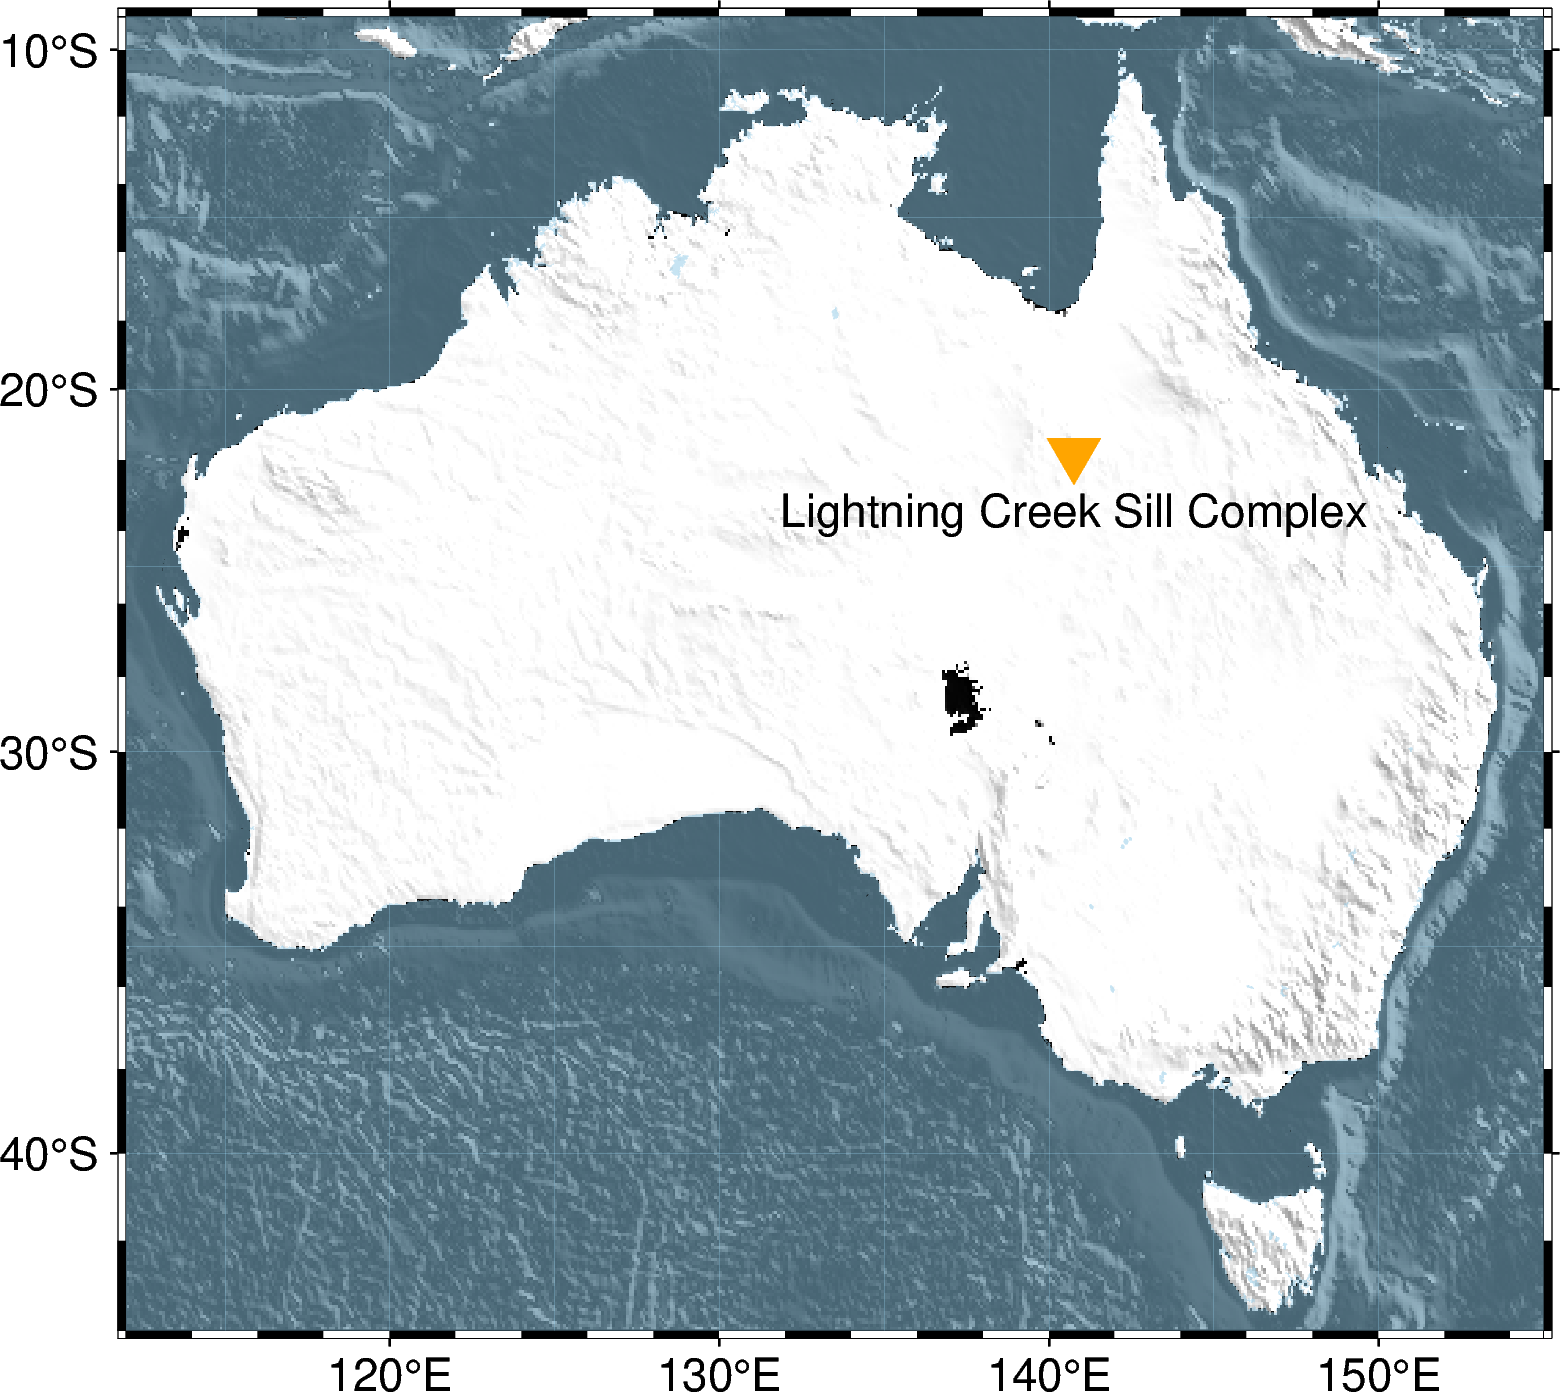

In [7]:
region_degrees_pad = (112, 155, -44, -9)
west, east, south, north = region_degrees[:]
lon_center, lat_center = np.mean([west, east]), np.mean([south, north])

fig = pygmt.Figure()
gmt_projection = "M12c"

pygmt.makecpt(cmap="gray")
fig.grdimage(
    "@earth_relief_05m",
    region=region_degrees_pad,
    projection=gmt_projection,
    shading="+a45+nt0.7",
    frame="af",
    cmap=True,
)
fig.coast(
    water="#8fcae7",
    transparency=50,
)

fig.plot(x=[lon_center], y=[lat_center], projection=gmt_projection, style="i15p", fill="orange")
fig.text(text="Lightning Creek Sill Complex", x=lon_center, y=lat_center - 1.6)

fig.savefig(figsdir / "lightning-creek-location-map.png", dpi=300, transparent=True)
fig.show()

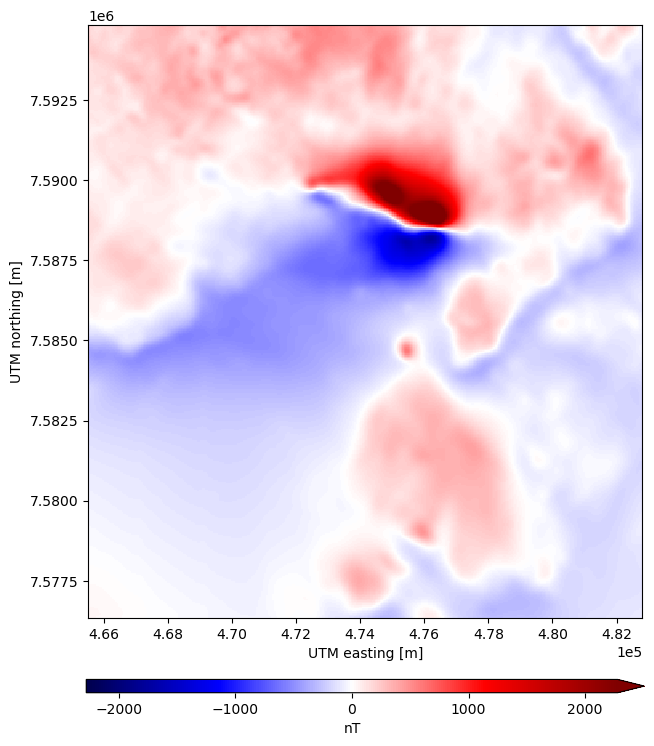

In [8]:
scale = vd.maxabs(magnetic_grid) * 0.6

plt.figure(figsize=(12, 10))
tmp = magnetic_grid.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
plt.savefig(figsdir / "lightning-creek-tf-anomaly.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Pad magnetic grid

In [9]:
pad_width = {
    "easting": magnetic_grid.easting.size * 2,
    "northing": magnetic_grid.northing.size * 2,
}
magnetic_grid_no_height = magnetic_grid.drop_vars("height")
magnetic_grid_padded = xrft.pad(magnetic_grid_no_height, pad_width=pad_width)
magnetic_grid_padded

<xarray.DataArray 'total_field_anomaly' (northing: 1850, easting: 1730)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * easting   (easting) float64 4.309e+05 4.31e+05 ... 5.173e+05 5.174e+05
  * northing  (northing) float64 7.539e+06 7.539e+06 ... 7.632e+06 7.632e+06
Attributes:
    Conventions:   CF-1.8
    title:         Magnetic total-field anomaly of the Lightning Creek sill c...
    crs:           proj=utm zone=54 south datum=WGS84 units=m no_defs ellps=W...
    source:        Interpolated from airborne magnetic line data using gradie...
    license:       Creative Commons Attribution 4.0 International Licence
    references:    Geophysical Acquisition & Processing Section 2019. MIM Dat...
    long_name:     total-field magnetic anomaly
    units:         nT
    actual_range:  [-1785.  3798.]

## Reduction to the pole

In [10]:
inclination, declination = -52.98, 6.51

In [11]:
rtp_grid = hm.reduction_to_pole(
    magnetic_grid_padded, inclination=inclination, declination=declination
)

# Unpad the reduced to the pole grid
rtp_grid = xrft.unpad(rtp_grid, pad_width)
rtp_grid

<xarray.DataArray (northing: 370, easting: 346)>
array([[  16.93705197,   13.21909213,   12.83890377, ..., -222.23901243,
        -213.42087047, -181.95752217],
       [  -0.6649667 ,   -6.75056907,   -8.34948274, ..., -167.62572332,
        -160.59818984, -135.85690628],
       [   0.44100267,   -6.63411214,   -8.55217998, ..., -173.28394383,
        -167.80590291, -143.67866746],
       ...,
       [  59.5174793 ,  -10.69762171,  -37.14385576, ...,  -35.48497238,
         -59.10510223,  -71.00981456],
       [  51.08851873,  -22.90653811,  -44.15507573, ...,  -29.73328996,
         -50.75866522,  -66.16979977],
       [ -88.21033532, -141.42147514, -151.68005749, ...,  -31.99345026,
         -30.03641906,  -35.16255006]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

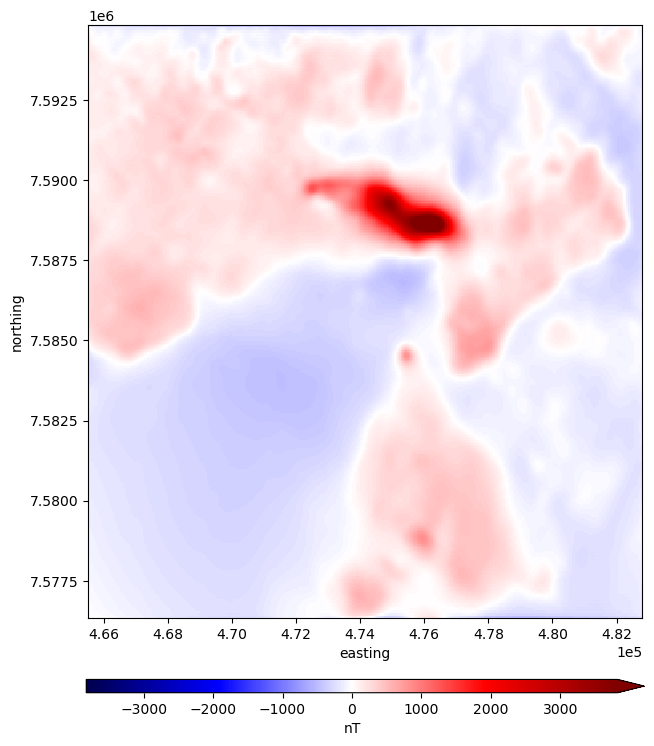

In [12]:
scale = vd.maxabs(rtp_grid) * 0.7

plt.figure(figsize=(12, 10))
tmp = rtp_grid.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
plt.savefig(figsdir / "lightning-creek-rtp.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Upward derivative

In [13]:
grid_padded = xrft.pad(rtp_grid, pad_width)
deriv_upward = hm.derivative_upward(grid_padded)
deriv_upward = xrft.unpad(deriv_upward, pad_width)
deriv_upward

<xarray.DataArray (northing: 370, easting: 346)>
array([[ 8.07474200e-01,  5.46420314e-01,  6.55472379e-01, ...,
        -4.60766218e+00, -4.59828845e+00, -5.23539780e+00],
       [-5.62203705e-02, -2.50913265e-01, -1.75389319e-01, ...,
         4.16805564e-03, -2.11904779e-01, -1.33999129e+00],
       [ 2.93265451e-01,  1.07199062e-01,  2.06796571e-01, ...,
        -1.09331128e+00, -1.34957308e+00, -2.40063823e+00],
       ...,
       [ 1.65688041e+00, -9.97391466e-01, -5.81939665e-01, ...,
        -4.17968218e-01, -6.45092041e-01, -1.54012856e+00],
       [ 3.26382364e+00,  5.66704924e-01,  1.05990594e+00, ...,
        -1.61273728e-01, -5.82501438e-01, -1.70340763e+00],
       [-3.44598640e+00, -4.59266234e+00, -4.25068453e+00, ...,
        -6.63387956e-01, -2.89404739e-01, -7.89053874e-01]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

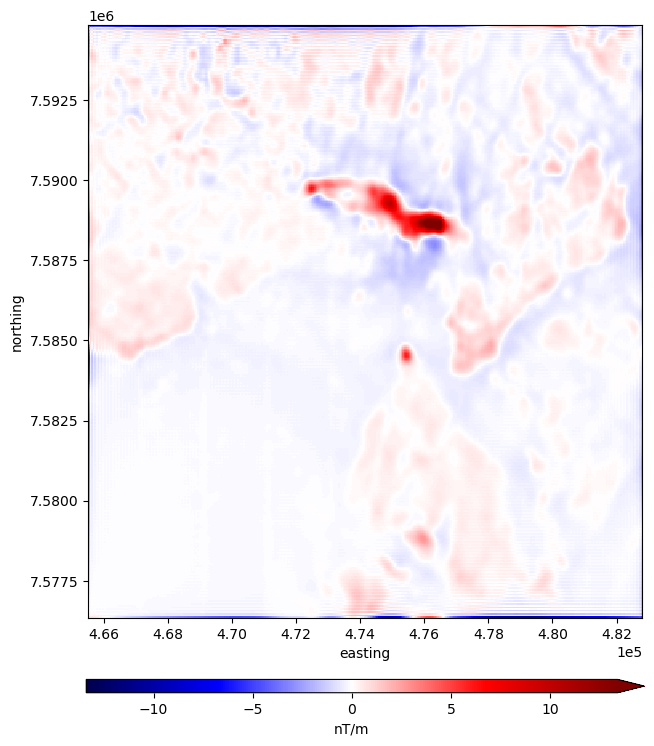

In [14]:
scale = vd.maxabs(deriv_upward) * 0.7

plt.figure(figsize=(12, 10))
tmp = deriv_upward.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT/m", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
plt.savefig(figsdir / "lightning-creek-rtp-deriv-upward.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Upward continuation

In [15]:
grid_padded = xrft.pad(rtp_grid, pad_width)
upward_cont = hm.upward_continuation(grid_padded, height_displacement=500)
upward_cont = xrft.unpad(upward_cont, pad_width)
upward_cont

<xarray.DataArray (northing: 370, easting: 346)>
array([[-20.94227768, -22.14119121, -23.39507774, ..., -49.42826002,
        -46.16390708, -42.88112256],
       [-22.07537501, -23.3818738 , -24.74785668, ..., -52.73910826,
        -49.19423009, -45.62715247],
       [-23.24837128, -24.66585029, -26.14681624, ..., -55.88074127,
        -52.07422547, -48.24199111],
       ...,
       [  7.92098316,   7.29068869,   6.53813128, ...,   3.00045485,
          1.85173539,   0.88382637],
       [  6.87554712,   6.22394352,   5.46663114, ...,   2.82648187,
          1.79604602,   0.92134372],
       [  6.03656983,   5.38906354,   4.65153762, ...,   2.59460145,
          1.68638459,   0.90908731]])
Coordinates:
  * northing  (northing) float64 7.576e+06 7.576e+06 ... 7.595e+06 7.595e+06
  * easting   (easting) float64 4.655e+05 4.656e+05 ... 4.827e+05 4.828e+05

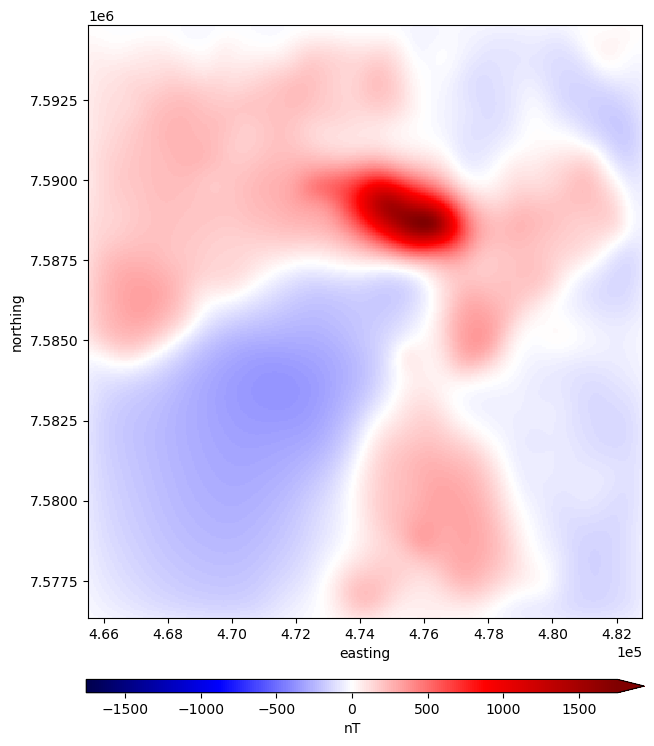

In [16]:
scale = vd.maxabs(upward_cont)

plt.figure(figsize=(12, 10))
tmp = upward_cont.plot(cmap="seismic", vmin=-scale, vmax=scale, add_colorbar=False)
plt.gca().set_aspect("equal")
plt.ticklabel_format(style="sci", scilimits=(0,0))
plt.colorbar(tmp, label="nT", orientation="horizontal", shrink=0.6, aspect=42, pad=0.08, extend="max")
plt.savefig(figsdir / "lightning-creek-rtp-upward-cont.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()